In [1]:
# Basic packages
import numpy as np
from matplotlib import pyplot as plt
import xarray as xr
import pandas as pd
import math
import netCDF4 as nc

# DateTime packages
from matplotlib.dates import DateFormatter
from datetime import datetime, timedelta
import time
import matplotlib.dates as mdates

# Stats packages
import scipy
import bottleneck as bn
import PyCO2SYS as pyco2
import gsw
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, r2_score
import statsmodels.api as sm
import seaborn as sns

# Logistical packages
import requests
from importlib import reload
import warnings
warnings.filterwarnings('ignore')

In [2]:
%cd '/Users/akbaskind/Documents/Python Scripts/phyto'
%run PLT.py

/Users/akbaskind/Documents/Python Scripts/phyto


# Pull Data

In [3]:
#The scope is always look like this so we did not need to change anything

import gspread
from df2gspread import df2gspread as d2g
from oauth2client.service_account import ServiceAccountCredentials

scope = [
   'https://spreadsheets.google.com/feeds',
         'https://www.googleapis.com/auth/drive']

# Name of our Service Account Key
google_key_file = 'servicecredentials.json'
credentials = ServiceAccountCredentials.from_json_keyfile_name(google_key_file, scope)
gc = gspread.authorize(credentials)

# Spreadsheet key
spreadsheet_key = '1uLRAvFDsTSfS-c45DiG-W6VMa8I1J7XD1O-pJA4fp10'

# Worksheet keys
wks_hydrocat620 = 'Hydrocat 620'
wks_hydrocat720 = 'Hydrocat 720'
wks_MV = 'MV'
wks_QP = 'QP'

#Opening the worksheet by using Worksheet ID
workbook = gc.open_by_key(spreadsheet_key)

## HYDROCAT 620
#Selecting which sheet to pulling the data
sheet = workbook.worksheet(wks_hydrocat620)
values = sheet.get_all_values()
hydrocat620 = pd.DataFrame(values[1:], columns = values[0])


## HYDROCAT 720
#Selecting which sheet to pulling the data
sheet = workbook.worksheet(wks_hydrocat720)
values = sheet.get_all_values()
hydrocat720 = pd.DataFrame(values[1:], columns = values[0])

## MV
#Selecting which sheet to pulling the data
sheet = workbook.worksheet(wks_MV)
values = sheet.get_all_values()
MV = pd.DataFrame(values[1:], columns = values[0])

## QP
#Selecting which sheet to pulling the data
sheet = workbook.worksheet(wks_QP)
values = sheet.get_all_values()
QP = pd.DataFrame(values[1:], columns = values[0])

In [4]:
for k in hydrocat620.keys():
    if k == 'DateTime' or k == 'time':
        hydrocat620[k] = pd.to_datetime(hydrocat620[k])
    else:
        hydrocat620[k] = pd.to_numeric(hydrocat620[k])

for k in hydrocat720.keys():
    if k == 'DateTime' or k == 'time':
        hydrocat720[k] = pd.to_datetime(hydrocat720[k])
    else:
        hydrocat720[k] = pd.to_numeric(hydrocat720[k])
        
for k in QP.keys():
    if k == 'DateTime' or k == 'time':
        QP[k] = pd.to_datetime(QP[k])
    else:
        QP[k] = pd.to_numeric(QP[k])
        
for k in MV.keys():
    if k == 'DateTime' or k == 'time':
        MV[k] = pd.to_datetime(MV[k])
    else:
        MV[k] = pd.to_numeric(MV[k])

# Decomposition
$$
\Delta [\text{H}^+] \approx \left[ \frac{\partial [\text{H}^+]}{\partial \text{T}} \Delta \text{T} \right]
+ \left[ \frac{\partial [\text{H}^+]}{\partial \text{S}} \Delta \text{S} \right]
+ \left[ \frac{\partial [\text{H}^+]}{\partial \text{TA}} \Delta \text{TA} \right]
+ \left[ \frac{\partial [\text{H}^+]}{\partial \text{DIC}} \Delta \text{DIC}_{\text{bio}} \right]
+ \left[ \frac{\partial [\text{H}^+]}{\partial \text{DIC}} \Delta \text{DIC}_{\text{flux}} \right]
+ \left[ \frac{\partial [\text{H}^+]}{\partial \text{DIC}} \Delta \text{DIC}_{\text{mix}}  \right]
$$

Each term in this equations consists of (A) a partial derivative of H+ in terms of *variable* and (B) the discrete time change of *variable*.


In [325]:
hydrocat620['Alkalinity [umol/kg]'] = 477.62 + 51.99 * hydrocat620['Salinity [PSU]']
hydrocat620

,DateTime,Temperature [degC],Salinity [PSU],DO [mg/L],raw pH [total],Fluorescence [ug-chl/L],pH final,pH (normalized to 15°C),Month-Year,Alkalinity [umol/kg]
0,2022-01-04 09:31:15.400,6.5078,30.7871,9.592,7.934479,7.478,7.934479,7.797240,2022-01-15 00:00:00,2078.241329
1,2022-01-04 10:46:15.400,6.3631,30.8278,9.663,7.934814,1.844,7.934814,7.795139,2022-01-15 00:00:00,2080.357322
2,2022-01-04 11:01:15.200,6.3063,30.7459,9.633,7.934773,2.373,7.934773,7.794166,2022-01-15 00:00:00,2076.099341
3,2022-01-04 11:16:15.200,6.2367,30.7015,9.680,7.934821,3.158,7.934821,7.793057,2022-01-15 00:00:00,2073.790985
4,2022-01-04 11:31:15.200,6.2593,30.6492,9.698,7.924688,2.170,7.924688,7.783583,2022-01-15 00:00:00,2071.071908
...,...,...,...,...,...,...,...,...,...,...
34421,2023-04-30 22:46:29.000,11.7928,28.4188,8.547,7.971222,0.021,7.971222,7.920264,2023-04-15 00:00:00,1955.113412
34422,2023-04-30 23:01:29.000,11.7991,28.4178,8.472,7.961210,0.020,7.961210,7.910442,2023-04-15 00:00:00,1955.061422
34423,2023-04-30 23:16:29.000,11.8380,28.3284,8.471,7.971013,0.021,7.971013,7.920790,2023-04-15 00:00:00,1950.413516
34424,2023-04-30 23:31:29.000,11.9170,28.1962,8.406,7.970686,0.020,7.970686,7.921743,2023-04-15 00:00:00,1943.540438


In [326]:
H620 = hydrocat620.resample('D', on='DateTime').mean()
count = hydrocat620.resample('D', on='DateTime').count()
COUNT = count['DateTime'] 
H620['Count'] = COUNT
H620_std = hydrocat620.resample('D', on='DateTime').std(ddof = 1)
H620_std['Count'] = COUNT
H620_std

,Temperature [degC],Salinity [PSU],DO [mg/L],raw pH [total],Fluorescence [ug-chl/L],pH final,pH (normalized to 15°C),Alkalinity [umol/kg],Count
DateTime,,,,,,,,,
2022-01-04,0.179768,0.208742,0.106122,0.009523,1.757430,0.009523,0.009260,10.852492,21
2022-01-05,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0
2022-01-06,0.028700,0.103267,0.049963,0.005837,0.701006,0.005837,0.006071,5.368864,3
2022-01-07,0.040776,0.023949,0.017213,0.000033,0.390804,0.000033,0.000648,1.245087,5
2022-01-08,0.053351,0.048136,0.210613,0.020341,1.084317,0.020341,0.019820,2.502586,35
...,...,...,...,...,...,...,...,...,...
2023-04-26,0.380328,0.114624,0.307381,0.050294,0.000785,0.050294,0.050694,5.959307,96
2023-04-27,0.153413,0.124133,0.344025,0.056255,0.000603,0.056255,0.056104,6.453685,96
2023-04-28,0.255594,0.060494,0.309689,0.044727,0.001600,0.044727,0.044601,3.145071,96


## Error propagation: pH
Supposedly, when taking the mean, the standard deviation is:

$$
\sigma = \sqrt{\sigma_{\text{mean}}^2 + (\frac{\sigma_{\text{instrumental}}}{\sqrt{n}})^2}
$$


In [327]:
H620_std['pH instrumemnt error'] = 0.1
ERR_PH = 0.1/(np.sqrt(H620_std['Count']))

H620_std['pH total error'] = np.sqrt(H620_std['pH final']**2 + ERR_PH**2)
H620_std

,Temperature [degC],Salinity [PSU],DO [mg/L],raw pH [total],Fluorescence [ug-chl/L],pH final,pH (normalized to 15°C),Alkalinity [umol/kg],Count,pH instrumemnt error,pH total error
DateTime,,,,,,,,,,,
2022-01-04,0.179768,0.208742,0.106122,0.009523,1.757430,0.009523,0.009260,10.852492,21,0.1,0.023809
2022-01-05,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0,0.1,NaN
2022-01-06,0.028700,0.103267,0.049963,0.005837,0.701006,0.005837,0.006071,5.368864,3,0.1,0.058029
2022-01-07,0.040776,0.023949,0.017213,0.000033,0.390804,0.000033,0.000648,1.245087,5,0.1,0.044721
2022-01-08,0.053351,0.048136,0.210613,0.020341,1.084317,0.020341,0.019820,2.502586,35,0.1,0.026448
...,...,...,...,...,...,...,...,...,...,...,...
2023-04-26,0.380328,0.114624,0.307381,0.050294,0.000785,0.050294,0.050694,5.959307,96,0.1,0.051319
2023-04-27,0.153413,0.124133,0.344025,0.056255,0.000603,0.056255,0.056104,6.453685,96,0.1,0.057173
2023-04-28,0.255594,0.060494,0.309689,0.044727,0.001600,0.044727,0.044601,3.145071,96,0.1,0.045877


## Error propagation: TA
Hongjie suggested using a fixed value for our TA uncertainty: 10 umol/kg.

In [328]:
ERR_TA = 10/(np.sqrt(H620_std['Count']))
H620_std['Alkalinity [umol/kg]'] = np.sqrt(H620_std['Alkalinity [umol/kg]']**2 + ERR_TA**2)
H620_std[H620_std > 1000] = np.nan
H620_std

,Temperature [degC],Salinity [PSU],DO [mg/L],raw pH [total],Fluorescence [ug-chl/L],pH final,pH (normalized to 15°C),Alkalinity [umol/kg],Count,pH instrumemnt error,pH total error
DateTime,,,,,,,,,,,
2022-01-04,0.179768,0.208742,0.106122,0.009523,1.757430,0.009523,0.009260,11.069710,21,0.1,0.023809
2022-01-05,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0,0.1,NaN
2022-01-06,0.028700,0.103267,0.049963,0.005837,0.701006,0.005837,0.006071,7.884037,3,0.1,0.058029
2022-01-07,0.040776,0.023949,0.017213,0.000033,0.390804,0.000033,0.000648,4.642224,5,0.1,0.044721
2022-01-08,0.053351,0.048136,0.210613,0.020341,1.084317,0.020341,0.019820,3.019947,35,0.1,0.026448
...,...,...,...,...,...,...,...,...,...,...,...
2023-04-26,0.380328,0.114624,0.307381,0.050294,0.000785,0.050294,0.050694,6.046073,96,0.1,0.051319
2023-04-27,0.153413,0.124133,0.344025,0.056255,0.000603,0.056255,0.056104,6.533890,96,0.1,0.057173
2023-04-28,0.255594,0.060494,0.309689,0.044727,0.001600,0.044727,0.044601,3.306529,96,0.1,0.045877


## Error propagation: T and S
The errors in T and S arise from taking monthly averages.

$$
\sigma_{\text{mean}} = \frac{\sigma_{\text{instrumental}}}{\sqrt{n}}
$$


In [329]:
ERR_T = 0.01/(np.sqrt(H620_std['Count']))
H620_std['Temperature [degC]'] = np.sqrt(H620_std['Temperature [degC]']**2 + ERR_T**2)
dT = H620_std['Temperature [degC]']

ERR_S = 0.01/(np.sqrt(H620_std['Count']))
H620_std['Salinity [PSU]'] = np.sqrt(H620_std['Salinity [PSU]']**2 + ERR_S**2)
dS = H620_std['Salinity [PSU]']
H620_std

,Temperature [degC],Salinity [PSU],DO [mg/L],raw pH [total],Fluorescence [ug-chl/L],pH final,pH (normalized to 15°C),Alkalinity [umol/kg],Count,pH instrumemnt error,pH total error
DateTime,,,,,,,,,,,
2022-01-04,0.179781,0.208753,0.106122,0.009523,1.757430,0.009523,0.009260,11.069710,21,0.1,0.023809
2022-01-05,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0,0.1,NaN
2022-01-06,0.029275,0.103429,0.049963,0.005837,0.701006,0.005837,0.006071,7.884037,3,0.1,0.058029
2022-01-07,0.041021,0.024363,0.017213,0.000033,0.390804,0.000033,0.000648,4.642224,5,0.1,0.044721
2022-01-08,0.053378,0.048166,0.210613,0.020341,1.084317,0.020341,0.019820,3.019947,35,0.1,0.026448
...,...,...,...,...,...,...,...,...,...,...,...
2023-04-26,0.380329,0.114629,0.307381,0.050294,0.000785,0.050294,0.050694,6.046073,96,0.1,0.051319
2023-04-27,0.153417,0.124137,0.344025,0.056255,0.000603,0.056255,0.056104,6.533890,96,0.1,0.057173
2023-04-28,0.255596,0.060502,0.309689,0.044727,0.001600,0.044727,0.044601,3.306529,96,0.1,0.045877


## Error propagation: DIC
We can calculate the error in DIC from PyCO2SYS.

In [330]:
TA = H620['Alkalinity [umol/kg]']
pH = H620['pH final']
dpH = H620_std['pH total error']
dT = H620_std['Temperature [degC]']
dS = H620_std['Salinity [PSU]']
dTA = H620_std['Alkalinity [umol/kg]']
S = H620['Salinity [PSU]']
T = H620['Temperature [degC]']

results = pyco2.sys(par1 = TA, par2 = pH, par1_type = 1, par2_type = 3, temperature = T, salinity = S,
                   uncertainty_into =["alkalinity", "dic","Hfree", 'pCO2'],
                   uncertainty_from ={"par2": 0.1/(np.sqrt(H620_std['Count']))})

In [333]:
H620['H+ [umol/kg]'] = results['Hfree']
H620['DIC [umol/kg]'] = results['dic']
H620['pCO2 [ppm]'] = results['pCO2']

H620_std['H+ [umol/kg]'] = results['u_Hfree']
H620_std['DIC [umol/kg]'] = results['u_dic']
H620_std['pCO2'] = results['u_pCO2']

## Step 2. Calculate the finite differences and partial derivatives
### Step 2a. Partial derivatives
I re-solve the carbonate system using TA and calculated DIC. I take the gradient of H+ with respect to (i.e. *wrt*) `par1` (in this case, DIC), `par2` (in this case, TA), temperature, and salinity. I add those to my table.

In [334]:
TA = H620['Alkalinity [umol/kg]']
DIC = H620['DIC [umol/kg]']
dDIC = H620_std['DIC [umol/kg]']
pH = H620['pH final']
S = H620['Salinity [PSU]']
T = H620['Temperature [degC]']

# Re-solve carb system using TA and DIC (total)
results = pyco2.sys(par1 = DIC, par2 = TA, par1_type = 2, par2_type = 1, temperature = T, salinity = S,
                    # Take grad of H+
                    grads_of=["Hfree"],
                    # In terms of par1 (which is DIC)
                    grads_wrt=["par1", 'temperature', 'salinity', 'par2'],
                    uncertainty_into =["pCO2", "Hfree"],
                    uncertainty_from ={"par1": dDIC})

H620['∂H/∂DIC'] = results['d_Hfree__d_par1']
H620['∂H/∂TA'] = results['d_Hfree__d_par2']
H620['∂H/∂T'] = results['d_Hfree__d_temperature']
H620['∂H/∂S'] = results['d_Hfree__d_salinity']


## Error propagation: [H+]

The error in [H+] comes from
1. pH
2. Alkalinity
3. T
4. S
5. DIC

In calculating DIC and its error, we have already accounted for errors in pH, TA, T, and S. Now we must also implement the error in DIC to get the error in [H+].

In [335]:
H620_std['H+ [umol/kg]'] = results['u_Hfree']
results['u_Hfree']

array([5.21631868e-04,            nan, 1.31754592e-03, 1.03608890e-03,
       3.69074228e-04, 7.75720276e-04, 3.40498591e-04, 3.07008044e-04,
       3.14993004e-04, 3.17288450e-04, 8.33144716e-04, 3.20796351e-04,
       3.05697245e-04, 4.28303131e-04, 2.60884898e-04, 2.46035465e-04,
       4.81703387e-04, 2.31488292e-04, 2.97519752e-04, 2.12927590e-04,
       2.13418740e-04, 2.10290299e-04, 1.63713736e-04, 1.56838789e-04,
       2.01306748e-04,            nan,            nan,            nan,
                  nan,            nan,            nan,            nan,
       2.62430386e-04, 2.08292916e-04, 1.09044069e-03, 2.65057173e-04,
       1.27169198e-04, 1.11913296e-04, 1.25174096e-04, 1.26599235e-04,
       2.96670475e-04, 1.26421499e-04, 1.35994377e-04, 1.59372540e-04,
       1.84722158e-04, 2.20714286e-04, 2.01002313e-04, 2.01250659e-04,
       1.88951204e-04, 1.95607740e-04, 2.13953027e-04, 2.07229796e-04,
       3.24495370e-04, 1.80957372e-04, 1.43744264e-04, 1.55560036e-04,
      

### Step 2b. Finite differences
I use `np.diff()` to do this. It is the difference in a variable over out time step.

In [336]:
H620['∆DIC'] = H620['DIC [umol/kg]'].diff()
H620['∆TA'] = H620['Alkalinity [umol/kg]'].diff()
H620['∆T'] = H620['Temperature [degC]'].diff()
H620['∆S'] = H620['Salinity [PSU]'].diff()

## Step 2. DIC mixing 
### Step 2a. Calculate ∆DIC mixing
We estimated this using the relationship between DIC and salinity from Pimenta et al. (2023). This says for every 1 PSU increase in salinity, DIC increases by 50.59 umol/kg.

$$
\text{DIC}_{\text{mix}} = 397.65 + 50.59 \times \text{S}
$$

In [305]:
H620['∆DIC_mix'] = (H620['Salinity [PSU]'] * 50.59).diff()

### Step 2b. Calculate ∆DIC_ASF
First, we calculate the air-sea flux of CO2. Functions are provided and yield units of molC/m2/yr. Ultimately, we want units of umol/kg/month, so we convert.

To get ∆DIC_ASF, we simply differentiate.

In [254]:
def co2flux(pco2_sea, pco2_air, sst, sss, wspd):
    """
    Inputs
        - pCO2_sea [uatm] or [ppm]
        - pCO2_air [uatm] or [ppm]
        - SST [°C]
        - SSS [PSU]
        - wind speed [m/s?]
    Output
        - CO2 upward flux [molC/m2/yr] 
    """
    kt = gas_transfer_velocity(sst,wspd)
    K0 = K0_Weiss(sst,sss)
    dpco2 = pco2_sea - pco2_air
    co2_flux = kt * K0 * dpco2 * (24*365/100000) # Because kt is in cm/hour, pCO2 is in µatm, flux in most case is in mol C/m2/yr
    return co2_flux

def K0_Weiss(sst,sss):
    sst = sst + 273.15 # transfer to Kelvin degree
    A1 =-58.0931
    A2 = 90.5069
    A3 = 22.294
    B1 = 0.027766
    B2 = -0.025888
    B3 = 0.0050578
    ln_K0 = A1 + A2 * (100/sst) + A3 * np.log(sst/100) + sss * (B1 + B2 * (sst/100) + B3 * (sst/100)**2)
    K0 = np.exp(ln_K0)
    return K0

def gas_transfer_velocity(sst,wspd):
    A = 2116.8 
    B = -136.25
    C = 4.7353
    D = -0.092307
    E = 0.000755
    c = 0.251
    Sc = A + B*(sst) + C*(sst**2) + D*(sst**3) + E*(sst**4) # Jähne et al. (1987), Wanninkhof 2014
    kt = c * wspd**2 *((Sc/660)**(-0.5)) # unit: cm/hour
    return kt

In [307]:
# molC/m2/yr
fgco2_ann = co2flux(H620['pCO2 [ppm]'], 410, H620['Temperature [degC]'], H620['Salinity [PSU]'], 5)
# molC/m2/month
fgco2_month = fgco2_ann/12
MLD = 8
# Density [kg/m3]
rho = gsw.rho(H620['Salinity [PSU]'].to_numpy(), H620['Temperature [degC]'].to_numpy(), np.zeros(len(H620)))
# umolC/kg/month
H620['DIC_flux [umolC/kg]'] = -(fgco2_month/MLD)*(1e6)/rho
H620['∆DIC_flux [umolC/kg]'] = H620['DIC_flux [umolC/kg]'].diff()
H620

,Temperature [degC],Salinity [PSU],DO [mg/L],raw pH [total],Fluorescence [ug-chl/L],pH final,pH (normalized to 15°C),Count,Alkalinity [umol/kg],H+ [umol/kg],...,∂H/∂S,∆DIC,∆TA,∆T,∆S,∆DIC_mix,DIC_flux [umolC/L],∆DIC_flux [umolC/L],DIC_flux [umolC/kg],∆DIC_flux [umolC/kg]
DateTime,,,,,,,,,,,,,,,,,,,,,
2022-01-04,6.165829,30.452386,9.769048,7.931652,2.820429,7.931652,7.788839,21,2060.839533,0.010381,...,0.000286,NaN,NaN,NaN,NaN,NaN,-19.906832,NaN,-19.906832,NaN
2022-01-05,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2022-01-06,6.428667,30.690967,9.882667,7.951120,3.680333,7.951120,7.812156,3,2073.243357,0.009910,...,0.000276,NaN,NaN,NaN,NaN,NaN,-15.367319,NaN,-15.367319,NaN
2022-01-07,6.223580,30.766000,9.746600,7.944959,3.683400,7.944959,7.802695,5,2077.144340,0.010061,...,0.000278,6.491697,3.900983,-0.205087,0.075033,3.795936,-17.082706,-1.715387,-17.082706,-1.715387
2022-01-08,5.578369,30.853269,10.095400,7.972001,4.712229,7.972001,7.818139,35,2081.681433,0.009482,...,0.000266,-0.822115,4.537093,-0.645211,0.087269,4.414917,-10.939591,6.143115,-10.939591,6.143115
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2023-04-26,11.674178,29.245377,8.657646,7.938050,0.022927,7.938050,7.885464,96,1998.087155,0.009965,...,0.000286,-17.860162,-9.335187,0.371563,-0.179557,-9.083807,-14.923260,6.463029,-14.923260,6.463029
2023-04-27,11.788653,29.004554,8.636156,7.922388,0.022625,7.922388,7.871813,96,1985.566771,0.010330,...,0.000296,-6.738194,-12.520383,0.114475,-0.240823,-12.183231,-18.382484,-3.459224,-18.382484,-3.459224
2023-04-28,11.857896,29.227630,8.792885,7.925714,0.022198,7.925714,7.876177,96,1997.164495,0.010243,...,0.000293,8.898318,11.597723,0.069243,0.223076,11.285417,-17.911048,0.471436,-17.911048,0.471436


### Step 2c. ∆DIC_bio

In [308]:
H620['∆DIC_bio [umolC/kg]'] = H620['∆DIC'] - H620['∆DIC_flux [umolC/kg]'] - H620['∆DIC_mix']

In [309]:
H620['∆TA_bio [umolC/kg]']=H620['∆DIC_bio [umolC/kg]']*(-16/107)
H620['∆TA_mix [umolC/kg]'] = (H620['Salinity [PSU]'] * 51.59).diff()

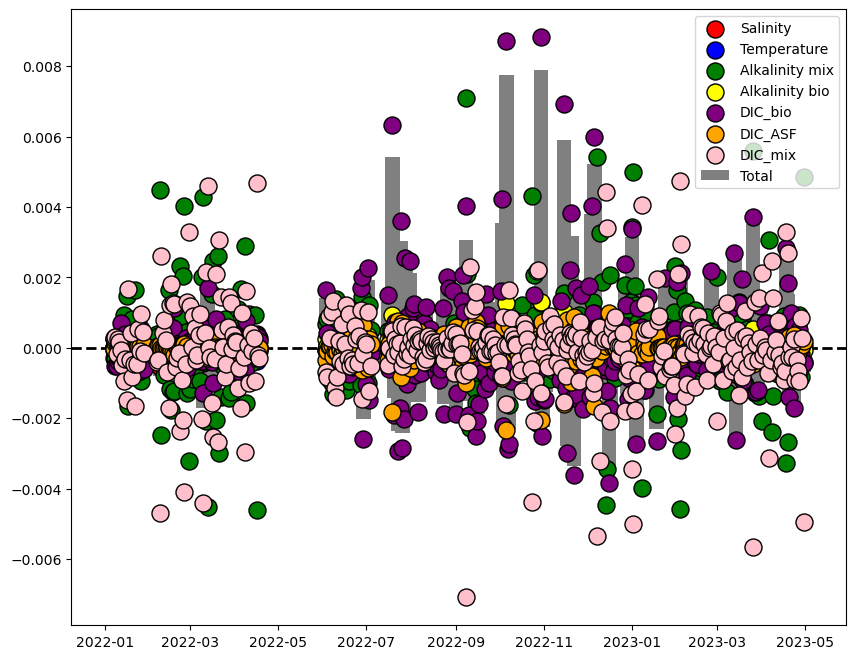

In [260]:
fig, ax = plt.subplots(figsize = [10,8])

# df.plot(x='Team', kind='bar', stacked=True,
#         title='Stacked Bar Graph by dataframe')

sal = H620['∂H/∂S'] * H620['∆S']
# ax.bar(H620.index, sal, width = 10, color = 'red', label = 'Salinity')
ax.scatter(H620.index, sal, facecolors = 'red', edgecolors = 'k', s = 150, label = 'Salinity', zorder = 3)

temp = H620['∂H/∂T'] * H620['∆T']
# ax.bar(H620.index, temp+sal, bottom = sal,width = 10, color = 'blue', label = 'Temperature')
ax.scatter(H620.index, temp, facecolors = 'blue', edgecolors = 'k', s = 150, label = 'Temperature', zorder = 3)

alk_mix = H620['∂H/∂TA'] * H620['∆TA_mix [umolC/L]']
# ax.bar(H620.index, alk, width = 10,label = 'Alkalinity')
ax.scatter(H620.index, alk_mix, facecolors = 'green', edgecolors = 'k', s = 150, label = 'Alkalinity mix', zorder = 3)

alk_bio = H620['∂H/∂TA'] * H620['∆TA_bio [umolC/L]']
# ax.bar(H620.index, alk, width = 10,label = 'Alkalinity')
ax.scatter(H620.index, alk_bio, facecolors = 'yellow', edgecolors = 'k', s = 150, label = 'Alkalinity bio', zorder = 3)

bio = H620['∂H/∂DIC'] * H620['∆DIC_bio [umolC/L]']
# ax.bar(H620.index, bio, width = 10,label = 'Biology')
ax.scatter(H620.index, bio, facecolors = 'purple', edgecolors = 'k', s = 150, label = 'DIC_bio', zorder = 3)

ASF = H620['∂H/∂DIC'] * H620['∆DIC_flux [umolC/L]']
# ax.bar(H620.index, ASF, width = 10,label = 'Air Sea Flux')
ax.scatter(H620.index, ASF, facecolors = 'orange', edgecolors = 'k', s = 150, label = 'DIC_ASF', zorder = 3)

mix = H620['∂H/∂DIC'] * H620['∆DIC_mix']
# ax.bar(H620.index, mix, width = 10,label = 'Mixing')
ax.scatter(H620.index, mix, facecolors = 'pink', edgecolors = 'k', s = 150, label = 'DIC_mix', zorder = 3)

ax.axhline(y=0.0, color='k', linestyle='dashed', lw = 2)
ax.bar(H620.index, mix + ASF + bio + alk_bio + alk_mix + temp + sal, color = 'gray', width = 10,label = 'Total')

ax.legend()

### Errors

Supposedly, the error for each term is described by
$$
\sigma_z = z \sqrt{(\frac{\sigma_x}{x})^2 + (\frac{\sigma_y}{y})^2}
$$

For temperature:
$$
\sigma_{\text{H-T}} = \text{H-T} \sqrt{(\frac{\sigma_{\text{H}}}{\text{H}})^2 + (\frac{\sigma_{\text{T}}}{\text{T}})^2}
$$

For salinity:
$$
\sigma_{\text{H-S}} = z \sqrt{(\frac{\sigma_{\text{H}}}{\text{H}})^2 + (\frac{\sigma_{\text{S}}}{\text{S}})^2}
$$

For TA terms:
$$
\sigma_{\text{H-TA}} = z \sqrt{(\frac{\sigma_{\text{H}}}{\text{H}})^2 + (\frac{\sigma_{\text{TA}}}{\text{TA}})^2}
$$

For all the DIC terms:
$$
\sigma_{\text{H-DIC}} = z \sqrt{(\frac{\sigma_{\text{H}}}{\text{H}})^2 + (\frac{\sigma_{\text{DIC}}}{\text{DIC}})^2}
$$

For the total:
$$
\sqrt{\sum_{n=\text{i}} \sigma_{\text{i}}^2}
$$

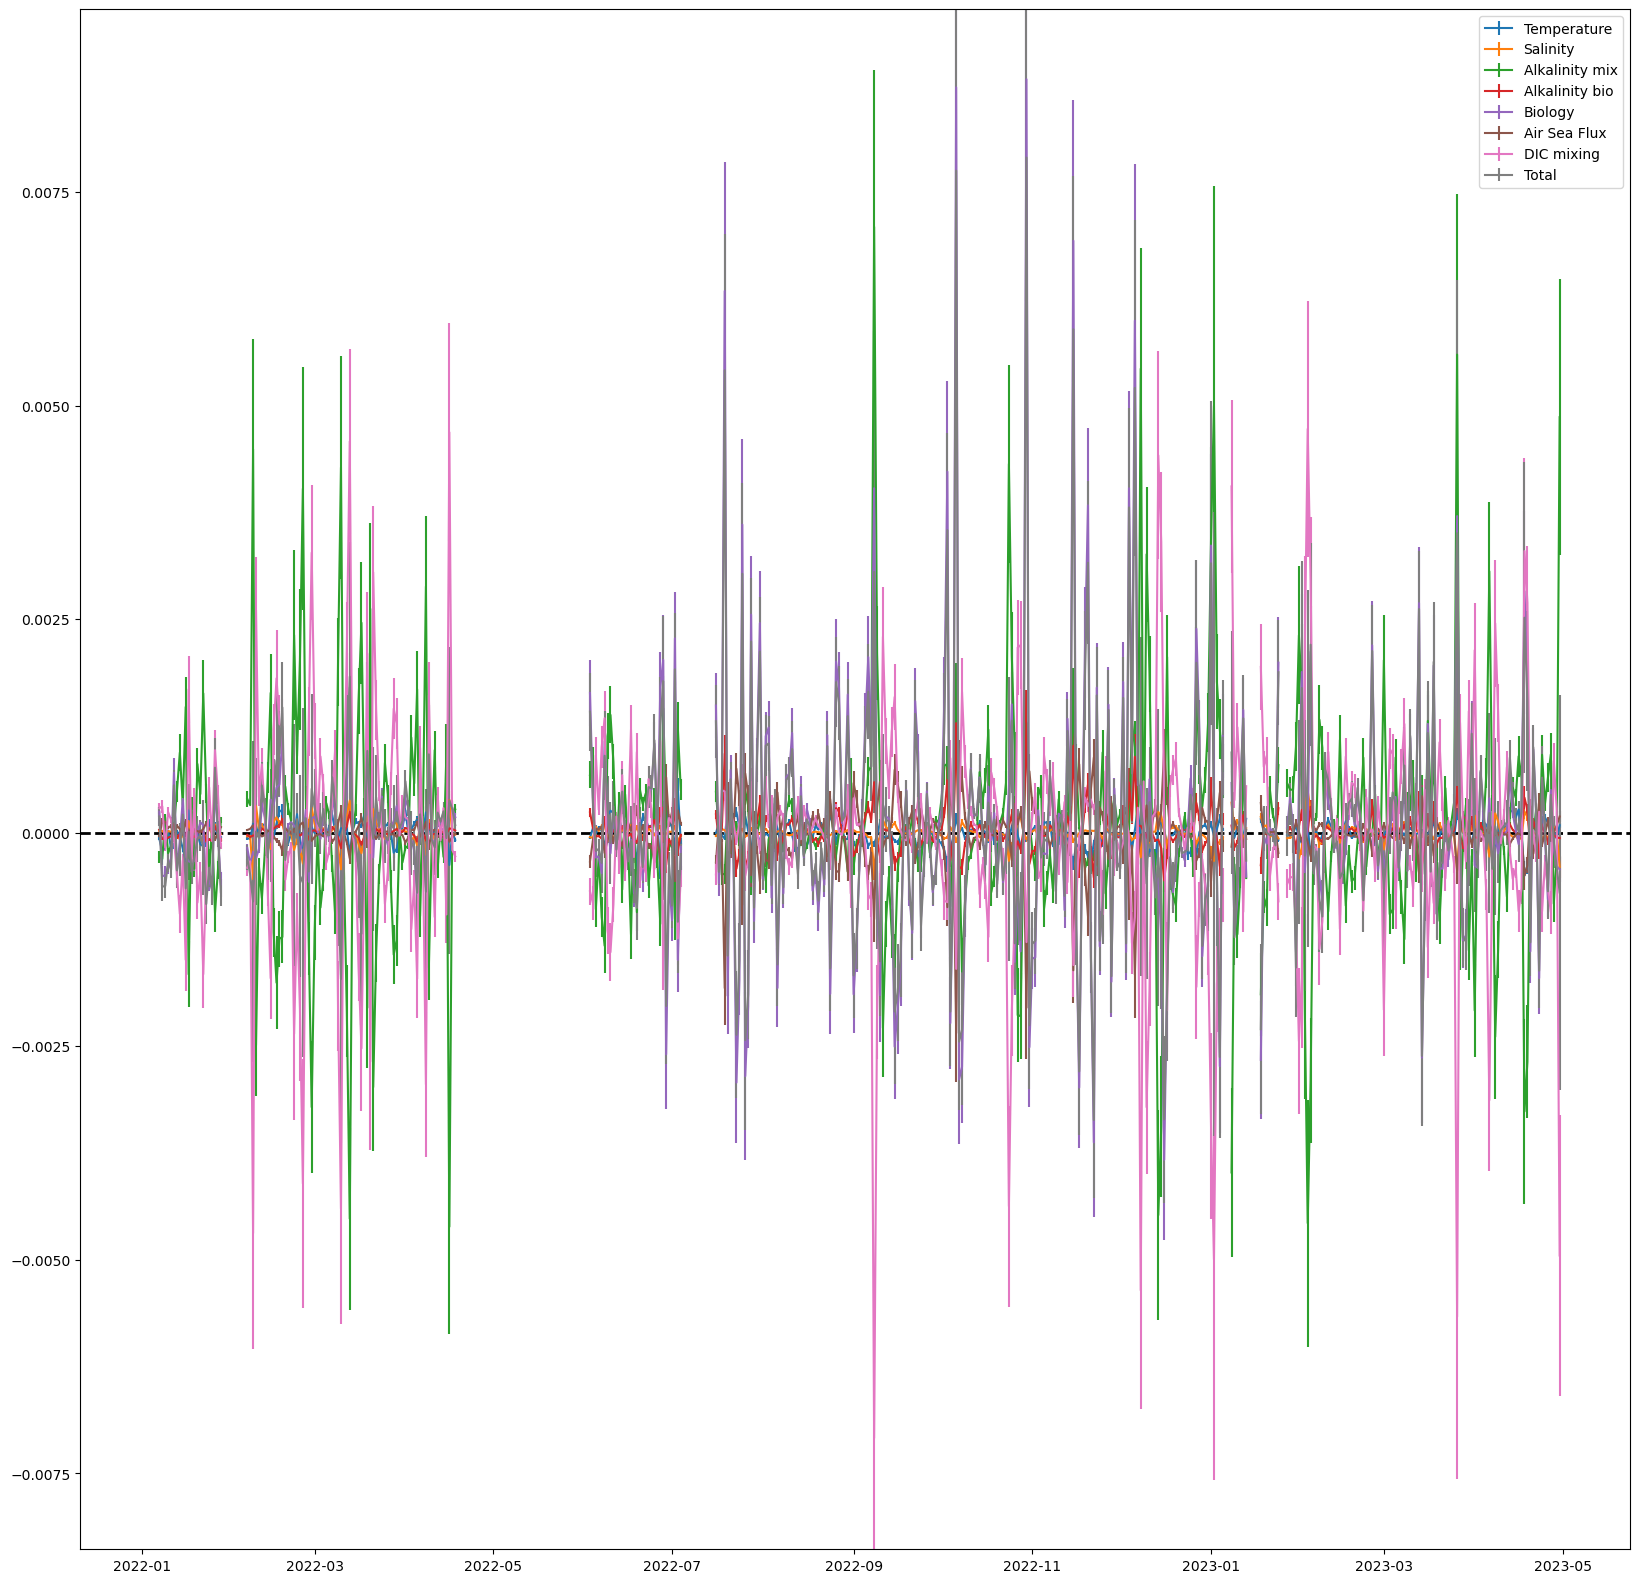

In [262]:
fig, ax = plt.subplots(figsize = [20,20])
TOTERR = 0

temp = H620['∂H/∂T'] * H620['∆T']
YERR = temp * np.sqrt((H620_std['Temperature [degC]']/H620['Temperature [degC]'])**2
        + (H620_std['H+ [umol/kg]']/H620['H+ [umol/kg]'])**2)
ax.errorbar(H620.index, temp, yerr = YERR, label = 'Temperature')
TOTERR += YERR**2

sal = H620['∂H/∂S'] * H620['∆S']
YERR = sal * np.sqrt((H620_std['Salinity [PSU]']/H620['Salinity [PSU]'])**2
        + (H620_std['H+ [umol/kg]']/H620['H+ [umol/kg]'])**2)
ax.errorbar(H620.index, sal, yerr = YERR, label = 'Salinity')
TOTERR += YERR**2

alk_mix = H620['∂H/∂TA'] * H620['∆TA_mix [umolC/L]']
YERR = alk_mix * np.sqrt((H620_std['Alkalinity']/H620['Alkalinity [umol/kg]'])**2
        + (H620_std['H+ [umol/kg]']/H620['H+ [umol/kg]'])**2)
ax.errorbar(H620.index, alk_mix, yerr = YERR, label = 'Alkalinity mix')
TOTERR += YERR**2

alk_bio = H620['∂H/∂TA'] * H620['∆TA_bio [umolC/L]']
YERR = alk_bio * np.sqrt((H620_std['Alkalinity']/H620['Alkalinity [umol/kg]'])**2
        + (H620_std['H+ [umol/kg]']/H620['H+ [umol/kg]'])**2)
ax.errorbar(H620.index, alk_bio, yerr = YERR, label = 'Alkalinity bio')
TOTERR += YERR**2

bio = H620['∂H/∂DIC'] * H620['∆DIC_bio [umolC/L]']
YERR = bio * np.sqrt((H620_std['DIC [umol/kg]']/H620['DIC [umol/kg]'])**2
        + (H620_std['H+ [umol/kg]']/H620['H+ [umol/kg]'])**2)
ax.errorbar(H620.index, bio, yerr = YERR, label = 'Biology')
TOTERR += YERR**2

ASF = H620['∂H/∂DIC'] * H620['∆DIC_flux [umolC/L]']
YERR = ASF * np.sqrt((H620_std['DIC [umol/kg]']/H620['DIC [umol/kg]'])**2
        + (H620_std['H+ [umol/kg]']/H620['H+ [umol/kg]'])**2)
ax.errorbar(H620.index, ASF, yerr = YERR, label = 'Air Sea Flux')
TOTERR += YERR**2

mix = H620['∂H/∂DIC'] * H620['∆DIC_mix']
YERR = mix * np.sqrt((H620_std['DIC [umol/kg]']/H620['DIC [umol/kg]'])**2
        + (H620_std['H+ [umol/kg]']/H620['H+ [umol/kg]'])**2)
ax.errorbar(H620.index, mix, yerr = YERR, label = 'DIC mixing')
TOTERR += YERR**2

ax.axhline(y=0.0, color='k', linestyle='dashed', lw = 2)
ax.errorbar(H620.index, mix + ASF + bio + alk_bio + alk_mix + temp + sal, yerr = np.sqrt(TOTERR),
            label = 'Total')

ax.legend()

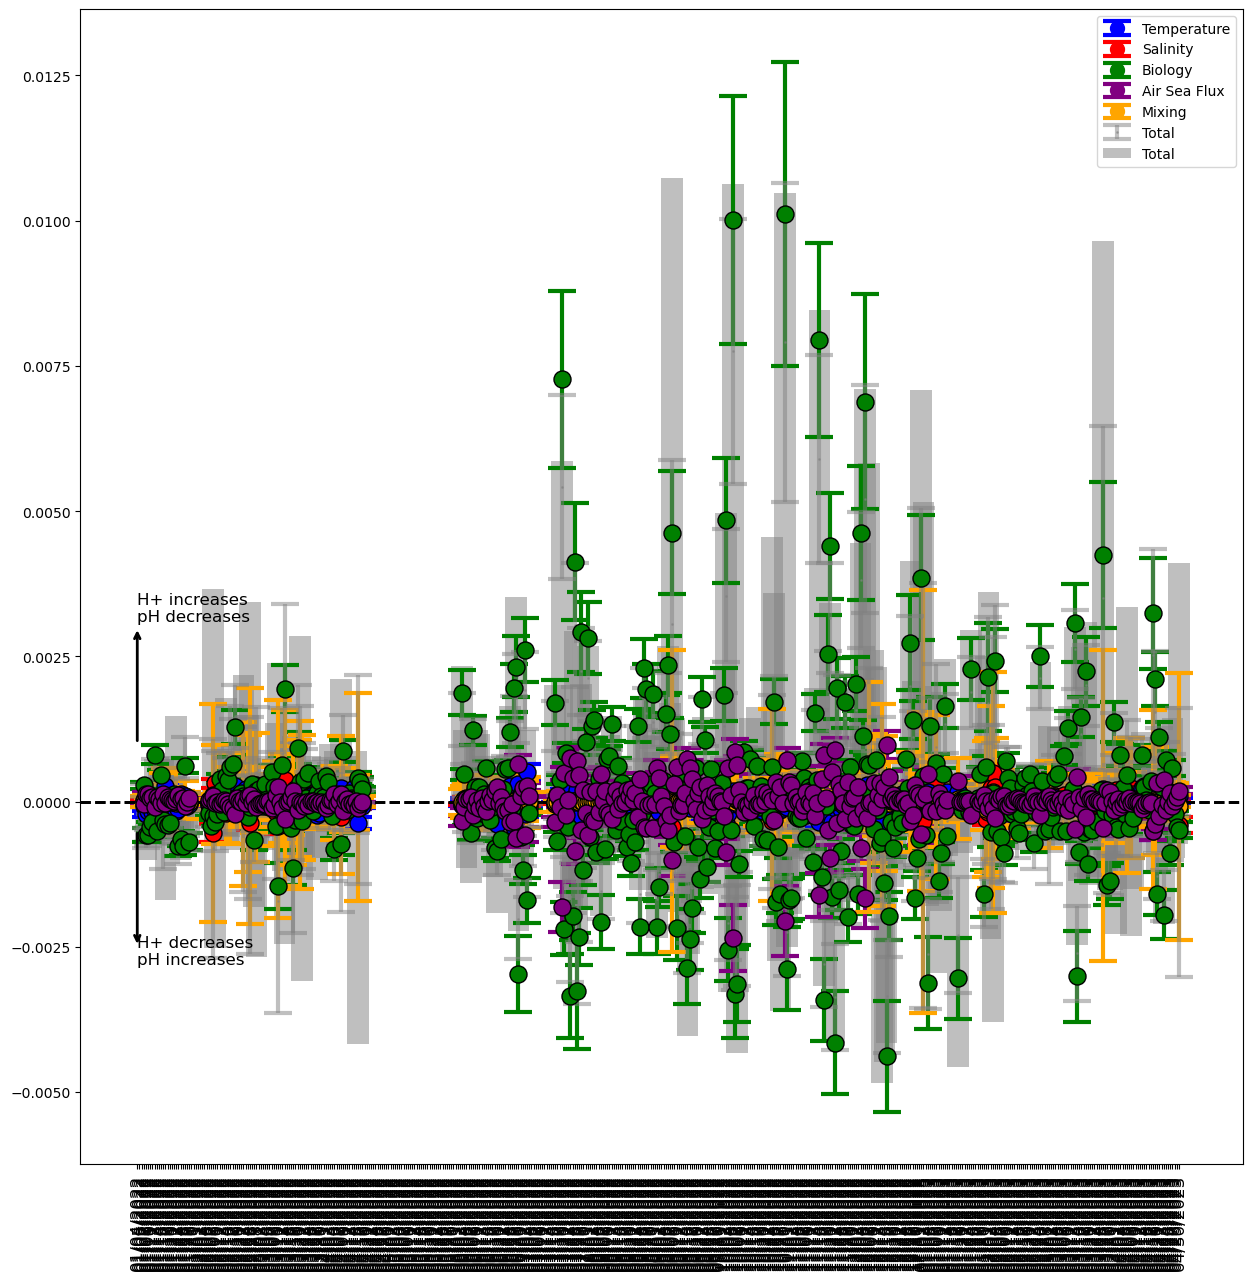

In [263]:
fig, ax = plt.subplots(figsize = [15,15])

# To calculate the total error
# each time I calculate an error for an individual component
# I will add the square to the total error
# And take the square root at the end
TOTERR = 0

# TEMPERATURE
temp = H620['∂H/∂T'] * H620['∆T']
YERR = temp * np.sqrt((H620_std['Temperature [degC]']/H620['Temperature [degC]'])**2
        + (H620_std['H+ [umol/kg]']/H620['H+ [umol/kg]'])**2)
ax.errorbar(H620.index, temp, yerr = YERR, label = 'Temperature',
            fmt='o',capsize = 10, color = 'blue', lw = 3, capthick = 3, markersize = 10)
TOTERR += YERR**2

# SALINITY
sal = H620['∂H/∂S'] * H620['∆S']
YERR = sal * np.sqrt((H620_std['Salinity [PSU]']/H620['Salinity [PSU]'])**2
        + (H620_std['H+ [umol/kg]']/H620['H+ [umol/kg]'])**2)
ax.errorbar(H620.index, sal, yerr = YERR, label = 'Salinity',
            fmt='o',capsize = 10, color = 'red', lw = 3, capthick = 3, markersize = 10)
TOTERR += YERR**2

# ALKALINITY MIXING (not plotted)
alk_mix = H620['∂H/∂TA'] * H620['∆TA_mix [umolC/L]']
YERR = alk_mix * np.sqrt((H620_std['Alkalinity']/H620['Alkalinity [umol/kg]'])**2
        + (H620_std['H+ [umol/kg]']/H620['H+ [umol/kg]'])**2)
TOTERR += YERR**2

# ALKALINITY BIO (not plotted)
alk_bio = H620['∂H/∂TA'] * H620['∆TA_bio [umolC/L]']
YERR = alk_bio * np.sqrt((H620_std['Alkalinity']/H620['Alkalinity [umol/kg]'])**2
        + (H620_std['H+ [umol/kg]']/H620['H+ [umol/kg]'])**2)
TOTERR += YERR**2

# DIC BIO (not plotted)
dic_bio = H620['∂H/∂DIC'] * H620['∆DIC_bio [umolC/L]']
YERR = dic_bio * np.sqrt((H620_std['DIC [umol/kg]']/H620['DIC [umol/kg]'])**2
        + (H620_std['H+ [umol/kg]']/H620['H+ [umol/kg]'])**2)
TOTERR += YERR**2

# TOTAL BIO = DIC BIO + ALK BIO
BIO = dic_bio + alk_bio
# Total bio error = sqrt(dic_bio_err^2 + alk_bio_err^2)
YERR1 = alk_bio * np.sqrt((H620_std['Alkalinity']/H620['Alkalinity [umol/kg]'])**2
        + (H620_std['H+ [umol/kg]']/H620['H+ [umol/kg]'])**2)
YERR2 = dic_bio * np.sqrt((H620_std['DIC [umol/kg]']/H620['DIC [umol/kg]'])**2
        + (H620_std['H+ [umol/kg]']/H620['H+ [umol/kg]'])**2)
YERR = np.sqrt(YERR1**2 + YERR2**2)
ax.errorbar(H620.index, BIO, yerr = YERR, label = 'Biology',
            fmt='o',capsize = 10, color = 'green', lw = 3, capthick = 3, markersize = 10)

# AIR SEA FLUX
ASF = H620['∂H/∂DIC'] * H620['∆DIC_flux [umolC/L]']
YERR = ASF * np.sqrt((H620_std['DIC [umol/kg]']/H620['DIC [umol/kg]'])**2
        + (H620_std['H+ [umol/kg]']/H620['H+ [umol/kg]'])**2)
ax.errorbar(H620.index, ASF, yerr = YERR, label = 'Air Sea Flux',
            fmt='o',capsize = 10, color = 'purple', lw = 3, capthick = 3, markersize = 10)
TOTERR += YERR**2

# DIC MIXING (not plotted)
dic_mix = H620['∂H/∂DIC'] * H620['∆DIC_mix']
YERR = dic_mix * np.sqrt((H620_std['DIC [umol/kg]']/H620['DIC [umol/kg]'])**2
        + (H620_std['H+ [umol/kg]']/H620['H+ [umol/kg]'])**2)
TOTERR += YERR**2

# TOTAL MIXING = DIC MIXING + ALK MIXING
# Total mix error = sqrt(dic_mix_err^2 + alk_mix_err^2)
MIX = dic_mix + alk_mix
YERR1 = alk_mix * np.sqrt((H620_std['Alkalinity']/H620['Alkalinity [umol/kg]'])**2
        + (H620_std['H+ [umol/kg]']/H620['H+ [umol/kg]'])**2)
YERR2 = dic_mix * np.sqrt((H620_std['DIC [umol/kg]']/H620['DIC [umol/kg]'])**2
        + (H620_std['H+ [umol/kg]']/H620['H+ [umol/kg]'])**2)
YERR = np.sqrt(YERR1**2 + YERR2**2)
ax.errorbar(H620.index, MIX, yerr = YERR, label = 'Mixing',
            fmt='o', capsize = 10, color = 'orange', lw = 3, capthick = 3, markersize = 10)

# TOTAL
ax.axhline(y=0.0, color='k', linestyle='dashed', lw = 2)
ax.errorbar(H620.index, mix + ASF + bio + alk_bio + alk_mix + temp + sal, yerr = np.sqrt(TOTERR),
            label = 'Total', color = 'gray', capsize = 10, fmt = 'o', lw = 3, capthick = 3, alpha = 0.5, markersize = 1)


sal = H620['∂H/∂S'] * H620['∆S']
ax.scatter(H620.index, sal, facecolors = 'red', edgecolors = 'k', s = 150, zorder = 3)

temp = H620['∂H/∂T'] * H620['∆T']
ax.scatter(H620.index, temp, facecolors = 'blue', edgecolors = 'k', s = 150, zorder = 3)

alk_mix = H620['∂H/∂TA'] * H620['∆TA_mix [umolC/L]']
dic_mix = H620['∂H/∂DIC'] * H620['∆DIC_mix']
mix = dic_mix + alk_mix
ax.scatter(H620.index, mix, facecolors = 'orange', edgecolors = 'k', s = 150, zorder = 3)

alk_bio = H620['∂H/∂TA'] * H620['∆TA_bio [umolC/L]']
dic_bio = H620['∂H/∂DIC'] * H620['∆DIC_bio [umolC/L]']
bio = alk_bio + dic_bio
ax.scatter(H620.index, bio, facecolors = 'green', edgecolors = 'k', s = 150, zorder = 3)


ASF = H620['∂H/∂DIC'] * H620['∆DIC_flux [umolC/L]']
ax.scatter(H620.index, ASF, facecolors = 'purple', edgecolors = 'k', s = 150, zorder = 3)

ax.axhline(y=0.0, color='k', linestyle='dashed', lw = 2)
ax.bar(H620.index, mix + ASF + bio + alk_bio + alk_mix + temp + sal, color = 'gray', width = 10,label = 'Total',
      alpha = 0.5)

ax.set_xticks(H620.index)
ax.set_xticklabels(H620.index.strftime('%m/%d/%Y'), fontsize = 14)
ax.tick_params('x',labelsize = 12, labelrotation = 90)

plt.annotate('',xy=(H620.index[0], 0.003),xytext=(H620.index[0], 0.001) ,horizontalalignment="center",
             arrowprops=dict(arrowstyle='->',lw=2))
ax.text(H620.index[0], 0.0031, 'H+ increases\npH decreases',
       fontsize = 12)
plt.annotate('',xy=(H620.index[0], -0.0025),xytext=(H620.index[0], -0.0005) ,horizontalalignment="center",
             arrowprops=dict(arrowstyle='->',lw=2))
ax.text(H620.index[0], -0.0028, 'H+ decreases\npH increases',
       fontsize = 12)

ax.legend()

In [238]:
H620.index

DatetimeIndex(['2022-01-31', '2022-02-28', '2022-03-31', '2022-04-30',
               '2022-05-31', '2022-06-30', '2022-07-31', '2022-08-31',
               '2022-09-30', '2022-10-31', '2022-11-30', '2022-12-31',
               '2023-01-31', '2023-02-28', '2023-03-31', '2023-04-30'],
              dtype='datetime64[ns]', name='DateTime', freq='M')

In [240]:
H620.index.strftime('%m/%Y')

Index(['01/2022', '02/2022', '03/2022', '04/2022', '05/2022', '06/2022',
       '07/2022', '08/2022', '09/2022', '10/2022', '11/2022', '12/2022',
       '01/2023', '02/2023', '03/2023', '04/2023'],
      dtype='object', name='DateTime')